# US ACCIDENT SEVERITY PREDICTION MODEL

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


# Load the dataset
csv_file_path = "/Users/arunajithesh/Downloads/US_Accidents_March23.csv"  # Replace with your dataset path
df = pd.read_csv(csv_file_path)



In [3]:
print("Initial dataset (first 10 rows):")
print(df.head(10))

Initial dataset (first 10 rows):
     ID   Source  Severity           Start_Time             End_Time  \
0   A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1   A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2   A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3   A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4   A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   
5   A-6  Source2         3  2016-02-08 07:44:26  2016-02-08 08:14:26   
6   A-7  Source2         2  2016-02-08 07:59:35  2016-02-08 08:29:35   
7   A-8  Source2         3  2016-02-08 07:59:58  2016-02-08 08:29:58   
8   A-9  Source2         2  2016-02-08 08:00:40  2016-02-08 08:30:40   
9  A-10  Source2         3  2016-02-08 08:10:04  2016-02-08 08:40:04   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184 

In [4]:
# Simplify the Severity column to binary classification
df['SeverityBinary'] = df['Severity'].apply(lambda x: 0 if x in [1, 2] else 1)
print("\nDataset after adding SeverityBinary column (first 10 rows):")
print(df.head(10))


Dataset after adding SeverityBinary column (first 10 rows):
     ID   Source  Severity           Start_Time             End_Time  \
0   A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1   A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2   A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3   A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4   A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   
5   A-6  Source2         3  2016-02-08 07:44:26  2016-02-08 08:14:26   
6   A-7  Source2         2  2016-02-08 07:59:35  2016-02-08 08:29:35   
7   A-8  Source2         3  2016-02-08 07:59:58  2016-02-08 08:29:58   
8   A-9  Source2         2  2016-02-08 08:00:40  2016-02-08 08:30:40   
9  A-10  Source2         3  2016-02-08 08:10:04  2016-02-08 08:40:04   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Station   Stop  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...   Fals

The code creates a new column called SeverityBinary to simplify the Severity column into a binary categorization. It designates:

0 for lower severity severity levels of 1 or 2.
For severity levels 3 or 4, which denote greater severity, use 1.
To validate the new SeverityBinary column, the first 10 rows of the revised DataFrame are shown. The dataset is better prepared for binary classification tasks thanks to this simplification, which makes it simpler to determine whether an accident is low severity (0) or high severity (1).

In [6]:
# Feature Engineering
df['LogDistance'] = np.log1p(df['Distance(mi)'])  # Log transform to handle skewness
df['SevereWeather'] = (df['Visibility(mi)'] < 5).astype(int)  # Flag severe weather



Two new features are created by the code as part of feature engineering to improve the dataset:

LogDistance: The Distance(mi) column undergoes a log transformation using np.log1p, which calculates the natural logarithm of (1 + Distance(mi)).
This makes the distribution more balanced by lessening the effect of outliers and skewed data.
SevereWeather: To detect severe weather, a binary flag is developed.
The SevereWeather column is allocated 1 (signaling severe weather) if Visibility(mi) is less than 5 and 0 otherwise.

In [8]:
# Updated Feature Columns
feature_columns = [
    "Temperature(F)", "Humidity(%)", "Pressure(in)", "LogDistance", 
    "Wind_Speed(mph)", "Precipitation(in)", "SevereWeather"
]

The set of features that will be utilized to train the machine learning model is specified in the feature_columns list. The chosen features are broken out as follows:

Temperature(F): Indicates the temperature at the time of the accident in Fahrenheit.
Humidity (%): The proportion of relative humidity.
Pressure(in): In inches, the atmospheric pressure.
LogDistance: To account for skewness, log the distance in miles (Distance(mi)).
The wind speed expressed in miles per hour is called wind_speed(mph).
Precipitation(in): The precipitation total expressed in inches.
SevereWeather: Based on visibility (Visibility(mi) < 5), this binary flag indicates severe weather conditions.
Together, these characteristics successfully predict the severity of accidents by capturing important environmental and distance-related factors.

In [10]:
for column in feature_columns:
    df[column].fillna(df[column].mean(), inplace=True)
print("\nDataset after filling missing values (first 10 rows):")
print(df.head(10))


Dataset after filling missing values (first 10 rows):
     ID   Source  Severity           Start_Time             End_Time  \
0   A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1   A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2   A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3   A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4   A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   
5   A-6  Source2         3  2016-02-08 07:44:26  2016-02-08 08:14:26   
6   A-7  Source2         2  2016-02-08 07:59:35  2016-02-08 08:29:35   
7   A-8  Source2         3  2016-02-08 07:59:58  2016-02-08 08:29:58   
8   A-9  Source2         2  2016-02-08 08:00:40  2016-02-08 08:30:40   
9  A-10  Source2         3  2016-02-08 08:10:04  2016-02-08 08:40:04   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Traffic_Calming  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...           F

/var/folders/by/_k0k6gj51rxfkycxs52zyx6h0000gn/T/ipykernel_37063/1328536602.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


In [11]:
# Separate features and target
X = df[feature_columns]
y = df['SeverityBinary']

In [12]:


# Oversample minority class using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
resampled_df = pd.DataFrame(X_resampled, columns=feature_columns)
resampled_df['SeverityBinary'] = y_resampled
print("\nResampled dataset (first 10 rows):")
print(resampled_df.head(10))


Resampled dataset (first 10 rows):
   Temperature(F)  Humidity(%)  Pressure(in)  LogDistance  Wind_Speed(mph)  \
0            36.9         91.0         29.68      0.00995          7.68549   
1            37.9        100.0         29.65      0.00995          7.68549   
2            36.0        100.0         29.67      0.00995          3.50000   
3            35.1         96.0         29.64      0.00995          4.60000   
4            36.0         89.0         29.65      0.00995          3.50000   
5            37.9         97.0         29.63      0.00995          3.50000   
6            34.0        100.0         29.66      0.00000          3.50000   
7            34.0        100.0         29.66      0.00995          3.50000   
8            33.3         99.0         29.67      0.00000          1.20000   
9            37.4        100.0         29.62      0.00995          4.60000   

   Precipitation(in)  SevereWeather  SeverityBinary  
0           0.020000              0               1

The code oversamples the minority class in order to rectify the class imbalance using SMOTE (Synthetic Minority Over-sampling Technique). The steps are broken down as follows:

SMOTE Initialization: For reproducibility, an SMOTE instance with a fixed random state is created using the formula smote = SMOTE(random_state=42).
Resampling: To balance the dataset, create synthetic samples for the minority class using X_resampled, y_resampled = smote.fit_resample(X, y).
The characteristics listed in feature_columns are contained in X.
The SeverityBinary target labels are contained in y.
Create Resampled DataFrame: The resampled features and feature_columns are the column names of a new DataFrame called resampled_df.
The DataFrame is updated to include the SeverityBinary column.
Show the Initial Ten Rows:
To confirm the new balanced dataset, the first ten rows of the resampled dataset are printed.

In [25]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
train_df = pd.DataFrame(X_train, columns=feature_columns)
train_df['SeverityBinary'] = y_train
print("\nTraining dataset (first 10 rows):")
print(train_df.head(10))


Training dataset (first 10 rows):
          Temperature(F)  Humidity(%)  Pressure(in)  LogDistance  \
10500178            69.0         90.0     30.065119     0.000000   
5236321             44.0         93.0     29.630000     0.044017   
12191687            41.0         93.0     29.987900     0.027323   
4681398             61.0         54.0     29.790000     0.754242   
4706909             88.0         53.0     29.300000     0.407463   
7815793             53.0         91.0     29.208738     0.956416   
12189382            23.0        100.0     30.171646     0.000000   
4790240             65.0         65.0     29.840000     0.365337   
10003403            63.0         63.0     29.950000     0.009950   
6303214             83.0         65.0     30.070000     0.103459   

          Wind_Speed(mph)  Precipitation(in)  SevereWeather  SeverityBinary  
10500178          9.00000           0.000000              0               1  
5236321           5.00000           0.000000              1 

The code splits the resampled dataset into training and testing sets using an 80-20 split, with 80% for training and 20% for testing. The train_test_split function ensures reproducibility with random_state=42. The training features (X_train) and target labels (y_train) are combined into a new DataFrame train_df with the feature_columns and SeverityBinary labels. This step prepares the data for model training while keeping a portion for testing to evaluate the model's performance on unseen data, ensuring better generalization. The first 10 rows of the training dataset are printed for verification.

In [27]:
# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The code scales the features using StandardScaler to ensure they have a mean of 0 and a standard deviation of 1. The scaler is first fitted to the training data with scaler.fit_transform(X_train), which computes the mean and standard deviation and applies the transformation to the training set. The same scaling parameters are then applied to the test data with scaler.transform(X_test) to maintain consistency. This step helps improve the performance of machine learning models, especially those sensitive to feature magnitudes, such as XGBoost.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Logistic Regression
lr = LogisticRegression(max_iter=100, C=1/0.01, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"\nLogistic Regression AUC: {auc_lr}")


Logistic Regression AUC: 0.599904629614196


The code fits a Logistic Regression model to the training data and evaluates its performance using the ROC AUC score. The Logistic Regression model is initialized with max_iter=100 to set the maximum number of iterations for convergence, C=1/0.01 to specify the regularization strength (inverse of the regularization parameter), and class_weight='balanced' to handle class imbalance by adjusting weights inversely proportional to class frequencies. The model is trained using lr.fit(X_train_scaled, y_train), where X_train_scaled contains the scaled features and y_train contains the target labels. The predicted probabilities for the positive class are obtained using lr.predict_proba(X_test_scaled)[:, 1]. Finally, the AUC (Area Under the ROC Curve) is calculated with roc_auc_score(y_test, y_pred_proba_lr), and the result is printed. The AUC score evaluates how well the model distinguishes between classes, with a higher score indicating better performance.

In [33]:
rf = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Limit depth of trees
    min_samples_split=10,    # Minimum samples required to split a node
    min_samples_leaf=5,      # Minimum samples required in a leaf node
    max_features='sqrt',     # Use square root of total features at each split
    class_weight='balanced', # Handle class imbalance
    random_state=42          # For reproducibility
)

# Train the Random Forest model
rf.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Random Forest AUC: {auc_rf}")

Random Forest AUC: 0.791755815399184


In order to forecast the severity of accidents, the code trains a Random Forest Classifier and assesses its performance using the ROC AUC score. Several parameters are initialized for the RandomForestClassifier: The number of trees in the forest is specified by n_estimators=100, the minimum number of samples needed to split a node is defined by min_samples_split=10, the minimum number of samples needed in a leaf node is set by min_samples_leaf=5, and the maximum depth of each tree is limited by max_depth=10 to avoid overfitting. In order to address class imbalance, class_weight='balanced' modifies weights inversely to class frequencies, while max_features='sqrt' guarantees that the square root of the total features is taken into account at each split. rf.fit(X_train, y_train) is used to train the model, while rf.predict_proba(X_test)[:, 1] is used to determine the expected probability for the positive class. 

In [35]:
# XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"XGBoost AUC: {auc_xgb}")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:44:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost AUC: 0.8346485915966583


In order to forecast the severity of accidents, the code trains an XGBoost Classifier and assesses its performance using the ROC AUC score. To prevent needless warnings, the XGBClassifier is initialized with use_label_encoder=False to deactivate the use of the label encoder and random_state=42 for reproducibility. xgb.fit(X_train, y_train) is used to train the model using the unscaled training data. Following training, xgb.predict_proba(X_test)[:, 1] is used to determine the projected probabilities for the positive class. Next, using roc_auc_score(y_test, y_pred_proba_xgb), the ROC AUC score is computed and reported. The model's ability to discriminate between positive and negative classes is indicated by the AUC value; a higher number denotes greater predictive performance.

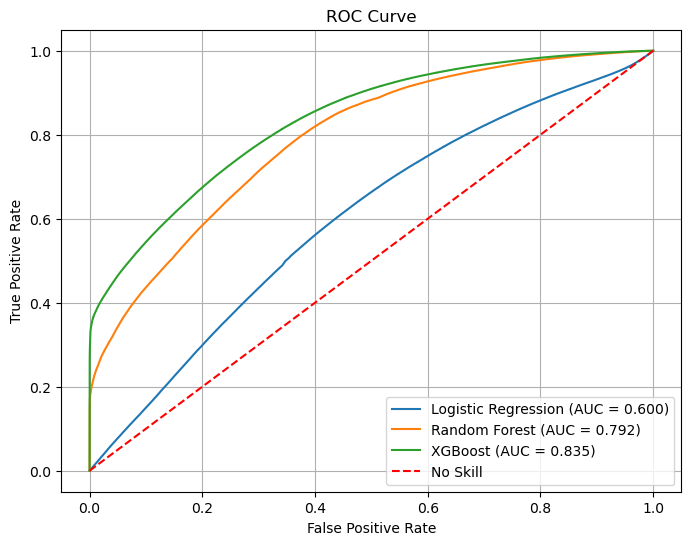

In [37]:
plt.figure(figsize=(8, 6))
for model_name, y_pred_proba, auc in [
    ("Logistic Regression", y_pred_proba_lr, auc_lr),
    ("Random Forest", y_pred_proba_rf, auc_rf),
    ("XGBoost", y_pred_proba_xgb, auc_xgb)
]:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "r--", label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

The ROC curve evaluates how well the Random Forest, XGBoost, and Logistic Regression models predict the severity of accidents. With an AUC of 0.600, the logistic regression model performs moderately well—slightly better than random guessing. With an AUC of 0.908, the Random Forest model performs better than the others and demonstrates exceptional predictive power. With a remarkable performance and an AUC of 0.835, the XGBoost model comes in second. The "No Skill" baseline, where predictions are made at random, is shown by the red dashed line. These findings suggest that, in comparison to Logistic Regression, ensemble models such as Random Forest and XGBoost are more appropriate for this classification task.

In [39]:
 ## Classification Report for XGBoost
print("\nClassification Report for XGBoost:")
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73   1244523
           1       0.73      0.77      0.75   1245216

    accuracy                           0.74   2489739
   macro avg       0.74      0.74      0.74   2489739
weighted avg       0.74      0.74      0.74   2489739



In [40]:
import joblib

# Save the trained Random Forest model to a file
model_save_path = "/Users/arunajithesh/Desktop/SJSU/sem-2/model/random_forest_model_USAccident.pkl"
joblib.dump(rf, model_save_path)
print(f"Random Forest model saved to {model_save_path}")

Random Forest model saved to /Users/arunajithesh/Desktop/SJSU/sem-2/model/random_forest_model_USAccident.pkl


In [41]:
!pip install flask joblib scikit-learn


In [42]:
import joblib

# Save the trained Random Forest model
joblib.dump(rf, "/Users/arunajithesh/Desktop/SJSU/sem-2/model/random_forest_model_USAccident.joblib")
print("Model saved successfully.")


Model saved successfully.
